# <center>Master M2 MVA 2017/2018 - Graphical models - HWK 2<center/>
### <center>WANG Yifan && CHU Xiao<center/>

## 4 Implementation - Gaussian mixtures
### (a) Implement the K-means algorithm. Represent graphically the training data, the cluster centers, as well as the different clusters. 

In [996]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [590]:
# Data loading
data_path = 'classification_data_HWK2/'
train = np.loadtxt(data_path + 'EMGaussian.data')
test = np.loadtxt(data_path + 'EMGaussian.test')
print(train.shape, test.shape)

(500, 2) (500, 2)


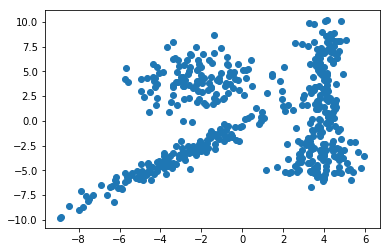

In [591]:
plt.scatter(train[:,0], train[:,1])
plt.show()

In [876]:
# K-means classifier

class KMeans(object):
    def __init__(self, k):
        self.k = k
        self.centers = None
        self.clusters = {}
        self.labels = None
        self.inertia = None
        self.label_history = []
        
    def train(self, X, init="random"):
        n = X.shape[0]
        centers = None
        # initialize
        if init == "random":
            self.centers = X[np.random.choice(n, self.k, replace=False)]
        elif init == 'kmeans++':
            # TODO: implement K-means++
            pass
        
        while (centers is None or np.abs(centers - self.centers).max() > 1e-5):
            # old centers
            centers = self.centers.copy()
            
            for i in range(self.k):
                self.clusters[i] = []
            labels = []
            for x in X:
                dis = np.sum((centers - x)**2, 1)
                label = np.argmin(dis)
                self.clusters[label].append(x)
                labels.append(label)
            self.labels = np.array(labels)
            self.label_history.append(self.labels)
            
            # new centers
            for i in range(self.k):
                self.centers[i] = np.mean(np.array(self.clusters[i]), 0)

In [877]:
clf = KMeans(4)
clf.train(train)

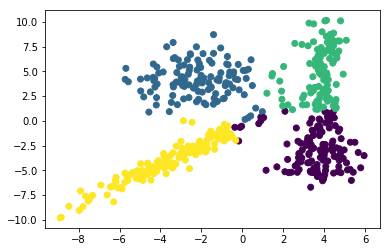

In [879]:
clf = KMeans(4)
clf.train(train)
plt.scatter(train[:,0], train[:,1], c=clf.labels)
plt.show()

In [595]:
from sklearn.cluster import KMeans as kmeans

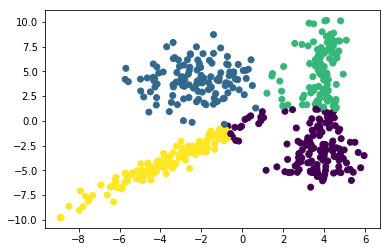

In [880]:
# sklearn kmeans
c = kmeans(4, init='random')
c.fit(train)
plt.scatter(train[:,0], train[:,1], c=c.labels_)
plt.show()

In [882]:
from scipy.stats import multivariate_normal as norm

def gamma(X, k, K, pis, mus, sigmas):
    """ Responsibilities
    """
    return (pis[k]* norm.pdf(X, mus[k], sigmas[k]))/(np.sum([pis[i]* norm.pdf(X, mus[i], sigmas[i]) for i in range(K)], 0))



In [974]:
# GMM classifier

class GMM(object):
    def __init__(self, k, covariance_type='full'):
        self.k = k
        self.mus = None
        self.alpha2 = None
        self.sigmas = None
        self.resp = None
        self.pis = None
        self.clusters = {}
        self.labels = None
        self.label_history = []
        self.covariance_type = covariance_type
        
    def train(self, X, init="kmeans"):
        n, d = X.shape
        centers = None
        # initialize
        if init == "kmeans":
            clf = KMeans(self.k)
            clf.train(X)
            self.mus = clf.centers
            self.labels = clf.labels
            self.pis = np.array([len(clf.clusters[i])/n for i in range(self.k)])
            if self.covariance_type == 'spherical':
                self.alpha2 = np.array([np.sum((np.array(clf.clusters[i]) - self.mus[i]) ** 2)/len(clf.clusters[i])/2. for i in range(self.k)])
                self.sigmas = np.array([self.alpha2[i] * np.eye(d) for i in range(self.k)])
            elif self.covariance_type == 'full':
                self.sigmas = np.array([np.cov(np.array(clf.clusters[k]).T) for k in range(self.k)])
            self.resp = np.zeros((self.k, n))
            for i in range(self.k):
                self.resp[i] = np.array(gamma(X, i, self.k, self.pis, self.mus, self.sigmas))                

        t = 0
        resp = self.resp.copy()
        pis = self.pis.copy()
        mus = self.mus.copy()
        if self.covariance_type == 'spherical':
            alpha2 = self.alpha2.copy()
        sigmas = self.sigmas.copy()
        while t < 30:
            t += 1
            # update
            for i in range(self.k):
                pis[i] = np.mean(self.resp[i])
                mus[i] = np.sum(X * self.resp[i][:, np.newaxis], 0)/np.sum(self.resp[i])
                if self.covariance_type == 'spherical':
                    alpha2[i] = np.sum([(X[j] - self.mus[i]) ** 2 * self.resp[i,j] for j in range(n)])/np.sum(self.resp[i])/2.
                    sigmas[i] = alpha2[i] * np.eye(d)
                elif self.covariance_type == 'full':
                    sigmas[i] = np.sum([(X[j] - self.mus[i]).reshape(-1,1).dot((X[j] - self.mus[i]).reshape(1,-1)) * self.resp[i,j] for j in range(n)], 0)/np.sum(self.resp[i])
            for i in range(self.k):
                resp[i] = np.array(gamma(X, i, self.k, pis, mus, sigmas))
            self.resp = resp.copy()
            self.pis = pis.copy()
            self.mus = mus.copy()
            if self.covariance_type == 'spherical':
                self.alpha2 = alpha2.copy()
            self.sigmas = sigmas.copy()
        labels = np.zeros(n)
        for i in range(n):
            self.labels[i] = np.argmax(self.resp[:, i])
            
    def test(self, X):
        n, d = X.shape
        resp = np.zeros((self.k, n))
        for i in range(self.k):
            resp[i] = np.array(gamma(X, i, self.k, self.pis, self.mus, self.sigmas))        
        labels = np.zeros(n)
        for i in range(n):
            labels[i] = np.argmax(resp[:, i])
        return labels, resp
        
    def log_likelyhood(self, X):
        _, resp = self.test(X)
        return np.sum([[resp[k,i] * np.log(self.pis[k] * norm.pdf(X[i], self.mus[k], self.sigmas[k])) for k in range(self.k)] for i in range(n)])
    
    
    

In [987]:
clf = GMM(4, covariance_type='spherical')
clf.train(train)

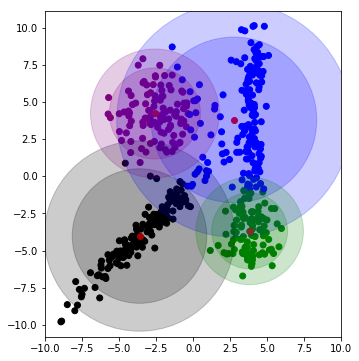

-5.4668707023729732

In [988]:
colors = ['black', 'blue', 'green', 'purple']
plt.figure(figsize=(6,6))
plt.scatter(train[:,0], train[:,1], c=clf.labels, cmap=mpl.colors.ListedColormap(colors))
plt.xlim((-10,10))
ax = plt.gca()
ax.set_aspect(1)
for i in range(4):
    r9 = np.sqrt(clf.alpha2[i] * 4.6) * 2
    r99 = np.sqrt(clf.alpha2[i] * 9.21) * 2
    ell9 = mpl.patches.Ellipse(clf.mus[i], r9, r9, color=colors[i])
    ell9.set_clip_box(ax.bbox)
    ell9.set_alpha(0.2)
    ell99 = mpl.patches.Ellipse(clf.mus[i], r99, r99, color=colors[i])
    ell99.set_clip_box(ax.bbox)
    ell99.set_alpha(0.2)
    ax.add_artist(ell9)
    ax.add_artist(ell99)
plt.scatter(clf.mus[:,0], clf.mus[:,1], color=['red'])
plt.show()
clf.log_likelyhood(train)/train.shape[0]

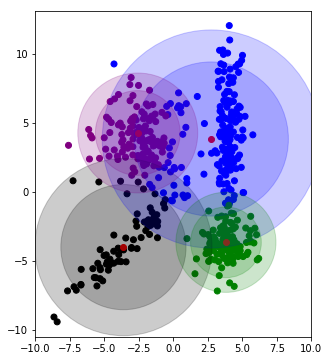

-5.42675210124


In [989]:
test_labels, _ = clf.test(test)
colors = ['black', 'blue', 'green', 'purple']
plt.figure(figsize=(6,6))
plt.scatter(test[:,0], test[:,1], c=test_labels, cmap=mpl.colors.ListedColormap(colors))
plt.xlim((-10,10))
ax = plt.gca()
ax.set_aspect(1)
for i in range(4):
    r9 = np.sqrt(clf.alpha2[i] * 4.6) * 2
    r99 = np.sqrt(clf.alpha2[i] * 9.21) * 2
    ell9 = mpl.patches.Ellipse(clf.mus[i], r9, r9, color=colors[i])
    ell9.set_clip_box(ax.bbox)
    ell9.set_alpha(0.2)
    ell99 = mpl.patches.Ellipse(clf.mus[i], r99, r99, color=colors[i])
    ell99.set_clip_box(ax.bbox)
    ell99.set_alpha(0.2)
    ax.add_artist(ell9)
    ax.add_artist(ell99)
plt.scatter(clf.mus[:,0], clf.mus[:,1], color=['red'])
plt.show()
print(clf.log_likelyhood(test)/test.shape[0])

In [938]:
from sklearn.mixture import GaussianMixture as GM

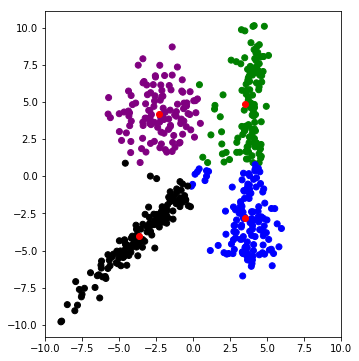

-5.306255436


In [939]:
# sklearn GMM
gm = GM(4, covariance_type='spherical', max_iter=100)
gm.fit(train)
colors = ['black', 'blue', 'green', 'purple']
plt.figure(figsize=(6,6))
plt.scatter(train[:,0], train[:,1], c=gm.predict(train), cmap=mpl.colors.ListedColormap(colors))
plt.scatter(gm.means_[:,0], gm.means_[:,1], color=['red'])
plt.xlim((-10,10))
ax = plt.gca()
ax.set_aspect(1)
plt.show()
print(gm.lower_bound_)

## Full covariance matrix

In [993]:
clf = GMM(4, covariance_type='full')
clf.train(train)

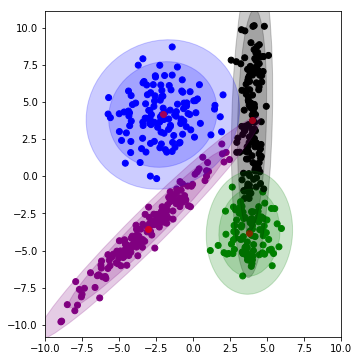

-4.7415007352635383

In [994]:
colors = ['black', 'blue', 'green', 'purple']
plt.figure(figsize=(6,6))
plt.scatter(train[:,0], train[:,1], c=clf.labels, cmap=mpl.colors.ListedColormap(colors))
plt.xlim((-10,10))
ax = plt.gca()
ax.set_aspect(1)
for i in range(4):
    # ref: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
    covariances = clf.sigmas[i]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v9 = 2. * np.sqrt(4.6) * np.sqrt(v)
    v99 = 2. * np.sqrt(9.21) * np.sqrt(v)
    ell9 = mpl.patches.Ellipse(clf.mus[i], v9[0], v9[1], 180 + angle, color=colors[i])
    ell9.set_clip_box(ax.bbox)
    ell9.set_alpha(0.2)
    ell99 = mpl.patches.Ellipse(clf.mus[i], v99[0], v99[1], 180 + angle, color=colors[i])
    ell99.set_clip_box(ax.bbox)
    ell99.set_alpha(0.2)
    ax.add_artist(ell9)
    ax.add_artist(ell99)
plt.scatter(clf.mus[:,0], clf.mus[:,1], color=['red'])
plt.show()
clf.log_likelyhood(train)/train.shape[0]

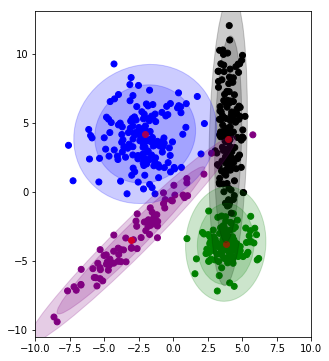

-4.90684025155


In [995]:
test_labels, _ = clf.test(test)

colors = ['black', 'blue', 'green', 'purple']
plt.figure(figsize=(6,6))
plt.scatter(test[:,0], test[:,1], c=test_labels, cmap=mpl.colors.ListedColormap(colors))
plt.xlim((-10,10))
ax = plt.gca()
ax.set_aspect(1)
for i in range(4):
    # ref: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py
    covariances = clf.sigmas[i]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v9 = 2. * np.sqrt(4.6) * np.sqrt(v)
    v99 = 2. * np.sqrt(9.21) * np.sqrt(v)
    ell9 = mpl.patches.Ellipse(clf.mus[i], v9[0], v9[1], 180 + angle, color=colors[i])
    ell9.set_clip_box(ax.bbox)
    ell9.set_alpha(0.2)
    ell99 = mpl.patches.Ellipse(clf.mus[i], v99[0], v99[1], 180 + angle, color=colors[i])
    ell99.set_clip_box(ax.bbox)
    ell99.set_alpha(0.2)
    ax.add_artist(ell9)
    ax.add_artist(ell99)
plt.scatter(clf.mus[:,0], clf.mus[:,1], color=['red'])
plt.show()
print(clf.log_likelyhood(test)/test.shape[0])

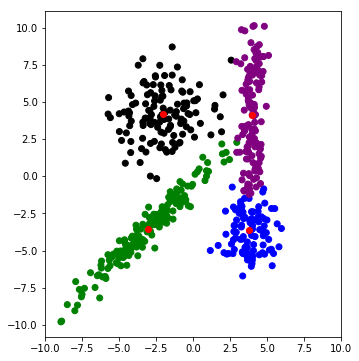

-4.6572392221


In [958]:
# sklearn GMM
gm = GM(4, covariance_type='full', max_iter=500)
gm.fit(train)
colors = ['black', 'blue', 'green', 'purple']
plt.figure(figsize=(6,6))
plt.scatter(train[:,0], train[:,1], c=gm.predict(train), cmap=mpl.colors.ListedColormap(colors))
plt.scatter(gm.means_[:,0], gm.means_[:,1], color=['red'])
plt.xlim((-10,10))
ax = plt.gca()
ax.set_aspect(1)
plt.show()
print(gm.lower_bound_)